Successfully loaded 'data_training.csv' and 'data_test.csv'.
Using RobustScaler.
'log_diff_total_revenue' is at index: 14 in scaled array.
Product 0: Created 299 sequences.
Product 1: Created 297 sequences.
Product 2: Created 299 sequences.
Product 3: Created 175 sequences.
Product 0: Created 25 sequences.
Product 1: Created 25 sequences.
Product 2: Created 25 sequences.
Product 3: Not enough data (38) for sequences. Req: 65. Skip.
X_train shape: (1070, 35, 15), y_train shape: (1070,)
X_test shape: (75, 35, 15), y_test shape: (75,), len(y_test_original_indices): 75


d:\Skripsi\Model Steps\Preprocessing\Step 1\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 100)            │        46,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,501 (181.64 KB)

 Trainable params: 46,501 (181.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step - loss: 0.9403 - mae: 0.7064 - rmse: 0.9649 - val_loss: 0.3457 - val_mae: 0.4588 - val_rmse: 0.5880 - learning_rate: 0.0050
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8245 - mae: 0.6689 - rmse: 0.9072 - val_loss: 0.3507 - val_mae: 0.4585 - val_rmse: 0.5922 - learning_rate: 0.0050
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9331 - mae: 0.7131 - rmse: 0.9651 - val_loss: 0.3578 - val_mae: 0.4629 - val_rmse: 0.5981 - learning_rate: 0.0050
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8072 - mae: 0.6637 - rmse: 0.8982 - val_loss: 0.3699 - val_mae: 0.4759 - val_rmse: 0.6082 - learning_rate: 0.0050
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8986 - mae: 0.6858 - rmse: 0.9457 - val_loss: 0.3448 - val_mae: 0.4548 - val_rmse: 0.5872 - learning_rate: 0.0050
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9099 - mae: 0.6857 - rmse: 0.9530 - val_loss: 0.3433 - va

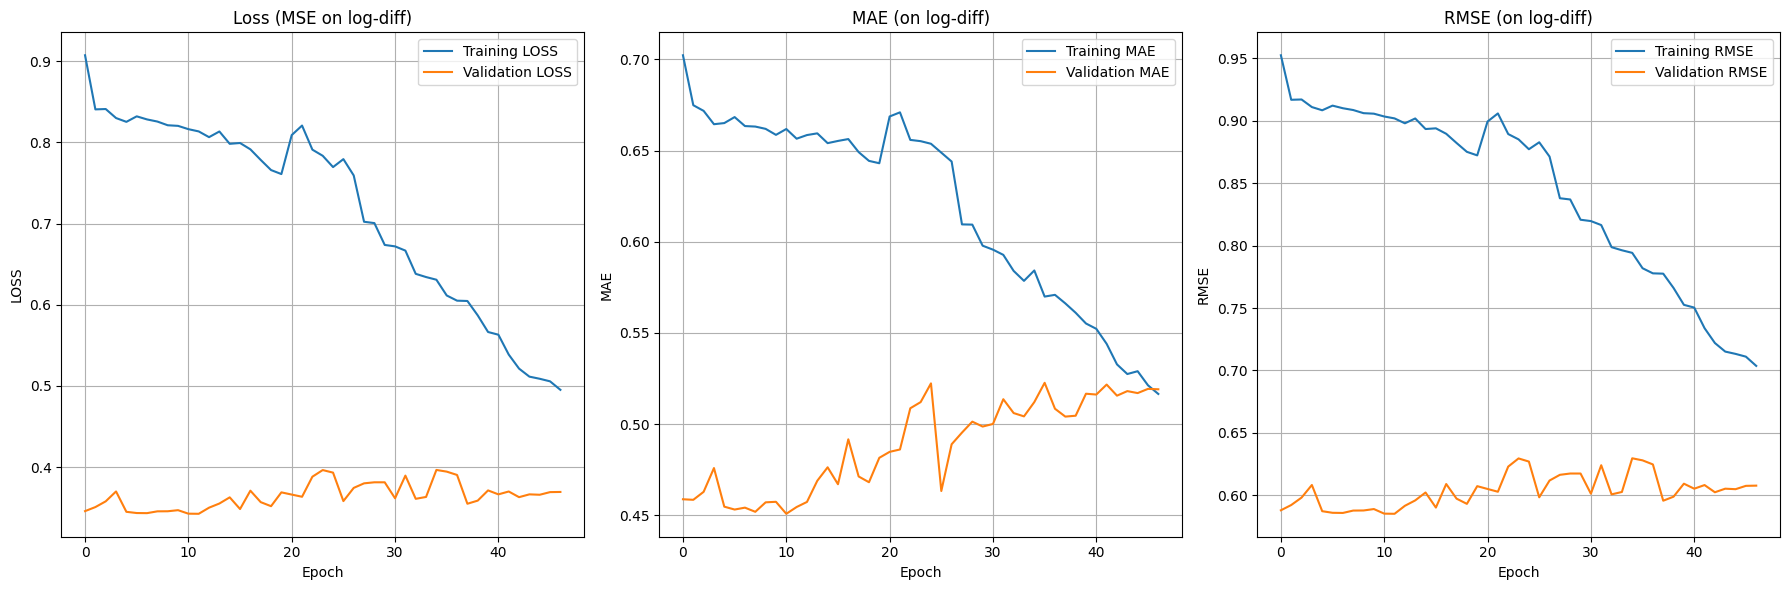

Evaluating model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step

--- Evaluation Metrics (on Log-Differenced Scale) ---
Test RMSE (of log-differences): 0.4309
Test MAE (of log-differences): 0.3347


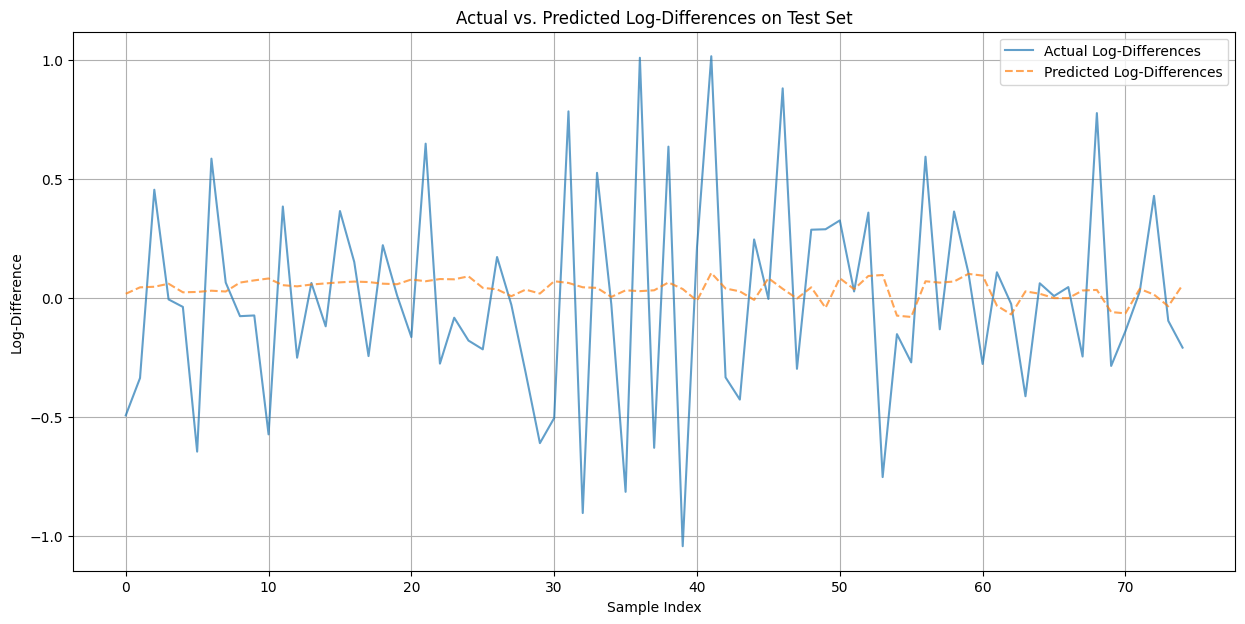


--- Evaluation Metrics (on Original Revenue Scale after Reconstruction) ---
Test RMSE (Original Scale): 701987.1088
Test MAE (Original Scale): 372186.3716
Test MAPE (Original Scale): 36.82%


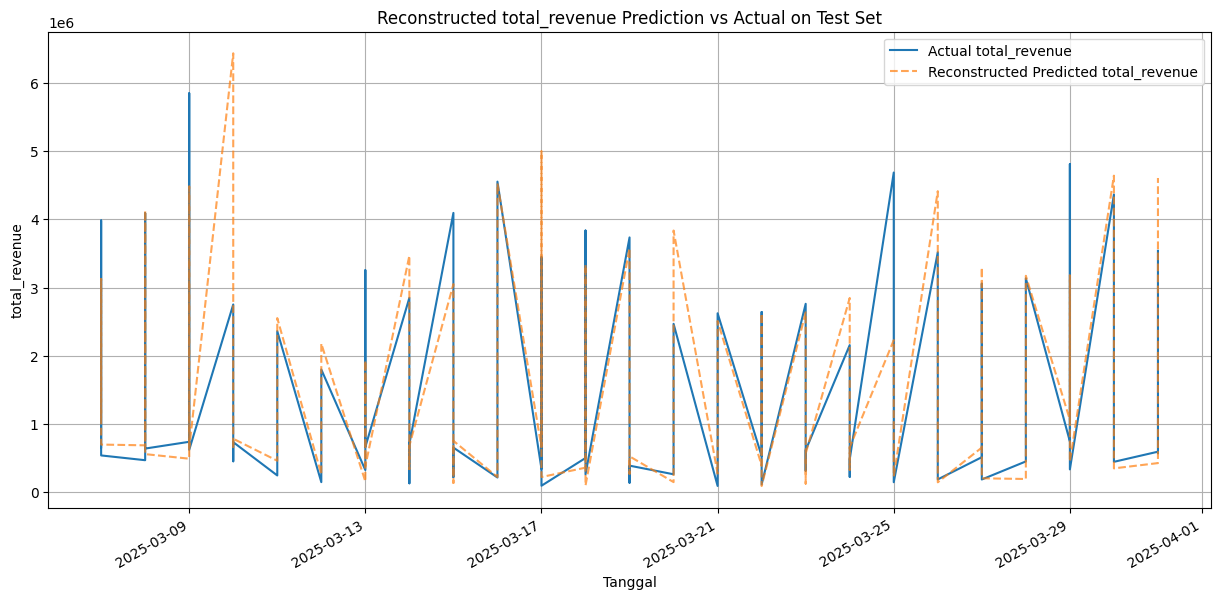

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 0. Configuration ---
SEQUENCE_LENGTH = 35
FORECAST_HORIZON = 30
TARGET_COLUMN = 'total_revenue'
LOG_TARGET_COLUMN = 'log_total_revenue'
LOG_DIFF_TARGET_COLUMN = 'log_diff_total_revenue'

FEATURE_COLUMNS = [
    'total_revenue',
    'total_revenue_ema_3',
    'total_revenue_roll_std_3', 'total_revenue_roll_min_3',
    'total_revenue_roll_max_3', 'total_revenue_ema_7',
    'total_revenue_roll_std_7', 'total_revenue_roll_min_7',
    'total_revenue_roll_max_7', 'total_revenue_ema_14',
    'total_revenue_roll_std_14', 'total_revenue_roll_min_14',
    'total_revenue_roll_max_14', 'produk_encoded'
]

# --- 1. Data Loading & Initial Preparation ---
try:
    train_df_orig = pd.read_csv('data_training.csv')
    test_df_orig = pd.read_csv('data_test.csv')
    print("Successfully loaded 'data_training.csv' and 'data_test.csv'.")
except FileNotFoundError:
    print("One or both CSV files not found."); exit()

def preprocess_log_difference_data(df, feature_cols_config, original_target_col, log_target_col, log_diff_target_col):
    df_copy = df.copy()
    df_copy['Tanggal'] = pd.to_datetime(df_copy['Tanggal'])
    df_copy.sort_values(by=['produk_encoded', 'Tanggal'], inplace=True)
    df_copy[log_target_col] = np.log1p(df_copy[original_target_col]) # log1p for stability if revenue can be 0
    df_copy[log_diff_target_col] = df_copy.groupby('produk_encoded')[log_target_col].diff()
    
    df_for_plotting_and_ref = df_copy[['Tanggal', original_target_col, log_target_col, 'produk_encoded', log_diff_target_col]].copy()
    df_copy.dropna(subset=[log_diff_target_col], inplace=True)
    df_for_plotting_and_ref = df_for_plotting_and_ref.loc[df_copy.index].reset_index(drop=True) 

    missing_features = [col for col in feature_cols_config if col not in df_copy.columns]
    if missing_features: raise ValueError(f"Missing features: {missing_features}")

    cols_for_scaling = feature_cols_config + [log_diff_target_col]
    df_features_and_log_diff_target = df_copy[cols_for_scaling].reset_index(drop=True)
    
    return df_features_and_log_diff_target, df_for_plotting_and_ref

train_df_processed, train_df_plot_ref = preprocess_log_difference_data(train_df_orig, FEATURE_COLUMNS, TARGET_COLUMN, LOG_TARGET_COLUMN, LOG_DIFF_TARGET_COLUMN)
test_df_processed, test_df_plot_ref = preprocess_log_difference_data(test_df_orig, FEATURE_COLUMNS, TARGET_COLUMN, LOG_TARGET_COLUMN, LOG_DIFF_TARGET_COLUMN)

# --- 2. Data Scaling ---
scaler = RobustScaler()
print("Using RobustScaler.")
scaled_train_data = scaler.fit_transform(train_df_processed)
scaled_test_data = scaler.transform(test_df_processed)

try:
    target_col_index_in_scaled_array = train_df_processed.columns.get_loc(LOG_DIFF_TARGET_COLUMN)
except KeyError:
    print(f"Col '{LOG_DIFF_TARGET_COLUMN}' not found. Available: {train_df_processed.columns.tolist()}"); exit()
print(f"'{LOG_DIFF_TARGET_COLUMN}' is at index: {target_col_index_in_scaled_array} in scaled array.")

# --- 3. Sequence Generation ---
def create_sequences_per_product(data_scaled, data_ref_df, sequence_length, forecast_horizon, target_idx_in_scaled, product_col_name='produk_encoded'):
    X_all, y_all, y_original_indices_all = [], [], [] 
    unique_products = data_ref_df[product_col_name].unique()

    for product_id in unique_products:
        product_ref_df_rows = data_ref_df[data_ref_df[product_col_name] == product_id]
        current_product_scaled_data_rows = data_scaled[product_ref_df_rows.index]

        if len(current_product_scaled_data_rows) < sequence_length + forecast_horizon:
            print(f"Product {product_id}: Not enough data ({len(current_product_scaled_data_rows)}) for sequences. Req: {sequence_length + forecast_horizon}. Skip.")
            continue
        
        X_prod, y_prod, y_orig_idx_prod = [], [], []
        for i in range(len(current_product_scaled_data_rows) - sequence_length - forecast_horizon + 1):
            X_prod.append(current_product_scaled_data_rows[i:(i + sequence_length), :])
            target_val_scaled = current_product_scaled_data_rows[i + sequence_length + forecast_horizon - 1, target_idx_in_scaled]
            y_prod.append(target_val_scaled)
            original_df_index_for_y = product_ref_df_rows.index[i + sequence_length + forecast_horizon - 1]
            y_orig_idx_prod.append(original_df_index_for_y)
            
        if X_prod:
            X_all.extend(X_prod); y_all.extend(y_prod); y_original_indices_all.extend(y_orig_idx_prod)
            print(f"Product {product_id}: Created {len(X_prod)} sequences.")
            
    if not X_all: return np.array([]), np.array([]), []
    return np.array(X_all), np.array(y_all), y_original_indices_all

X_train, y_train, _ = create_sequences_per_product(scaled_train_data, train_df_plot_ref, SEQUENCE_LENGTH, FORECAST_HORIZON, target_col_index_in_scaled_array)
X_test, y_test, y_test_original_indices = create_sequences_per_product(scaled_test_data, test_df_plot_ref, SEQUENCE_LENGTH, FORECAST_HORIZON, target_col_index_in_scaled_array)

if y_train.ndim > 1 and y_train.shape[1] == 1: y_train = y_train.ravel()
if y_test.ndim > 1 and y_test.shape[1] == 1: y_test = y_test.ravel()
if X_train.shape[0] == 0: print("No training sequences. Exiting."); exit()

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}, len(y_test_original_indices): {len(y_test_original_indices)}")

# --- 4. Build the LSTM Model (Adjusted Capacity & Regularization) ---
model = Sequential()
model.add(LSTM(units=100, # Increased units
               return_sequences=False,
               input_shape=(X_train.shape[1], X_train.shape[2]),
               )) # Slightly reduced L2
model.add(Dropout(0.2)) # Slightly reduced Dropout
# model.add(Dense(units=30, activation='relu', )) # Increased units, Slightly reduced L2
# model.add(Dropout(0.2)) # Slightly reduced Dropout
model.add(Dense(units=1))

# --- 5. Compile the Model ---
optimizer = Adam(learning_rate=0.005, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', RootMeanSquaredError(name='rmse')])
model.summary()

# --- 6. Train the Model ---
early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True, verbose=1) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, verbose=1, min_lr=0.000001)
callbacks_list = [early_stopping, reduce_lr] 
validation_data_param = (X_test, y_test) if X_test.shape[0] > 0 and y_test.shape[0] > 0 else None
if not validation_data_param: print("Warning: No test sequences for validation.")

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=validation_data_param, callbacks=callbacks_list if validation_data_param else [], verbose=1)

# --- PLOT TRAINING & VALIDATION LOSS/MAE/RMSE (on log-differenced scale) ---
if history and history.history:
    plt.figure(figsize=(18, 6))
    metrics_to_plot = {'loss': 'Loss (MSE on log-diff)', 'mae': 'MAE (on log-diff)', 'rmse': 'RMSE (on log-diff)'}
    for i, (metric, title) in enumerate(metrics_to_plot.items()):
        plt.subplot(1, 3, i + 1)
        plt.plot(history.history[metric], label=f'Training {metric.upper()}')
        if f'val_{metric}' in history.history: plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.upper()}')
        plt.title(title); plt.xlabel('Epoch'); plt.ylabel(metric.upper()); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()
else: print("Skipping loss plots.")

# --- 7. Prediction & Evaluation (Uncommented and Verified) ---
if X_test.shape[0] > 0 and y_test.shape[0] > 0 and history is not None and len(y_test_original_indices) == len(y_test):
    print("Evaluating model...")
    predictions_scaled_log_diff = model.predict(X_test)

    dummy_preds = np.zeros((len(predictions_scaled_log_diff), scaled_test_data.shape[1]))
    dummy_preds[:, target_col_index_in_scaled_array] = predictions_scaled_log_diff.ravel()
    unscaled_predicted_log_diffs = scaler.inverse_transform(dummy_preds)[:, target_col_index_in_scaled_array]

    dummy_y = np.zeros((len(y_test), scaled_test_data.shape[1]))
    dummy_y[:, target_col_index_in_scaled_array] = y_test.ravel()
    unscaled_actual_log_diffs = scaler.inverse_transform(dummy_y)[:, target_col_index_in_scaled_array]

    rmse_log_diff = np.sqrt(mean_squared_error(unscaled_actual_log_diffs, unscaled_predicted_log_diffs))
    mae_log_diff = mean_absolute_error(unscaled_actual_log_diffs, unscaled_predicted_log_diffs)
    print(f"\n--- Evaluation Metrics (on Log-Differenced Scale) ---")
    print(f"Test RMSE (of log-differences): {rmse_log_diff:.4f}")
    print(f"Test MAE (of log-differences): {mae_log_diff:.4f}")

    plt.figure(figsize=(15, 7))
    plt.plot(unscaled_actual_log_diffs, label='Actual Log-Differences', alpha=0.7)
    plt.plot(unscaled_predicted_log_diffs, label='Predicted Log-Differences', alpha=0.7, linestyle='--')
    plt.title('Actual vs. Predicted Log-Differences on Test Set'); plt.xlabel('Sample Index'); plt.ylabel('Log-Difference'); plt.legend(); plt.grid(True)
    plt.show()

    # --- Reconstruct to Original Revenue Scale ---
    reconstructed_revenue_predictions = []
    actual_revenue_for_comparison = []
    dates_for_reconstruction_plot = []

    
    
    for i in range(len(unscaled_predicted_log_diffs)):
        original_idx_in_ref_df = y_test_original_indices[i]
        
        log_revenue_t_minus_1 = test_df_plot_ref.loc[original_idx_in_ref_df, LOG_TARGET_COLUMN] - \
                                test_df_plot_ref.loc[original_idx_in_ref_df, LOG_DIFF_TARGET_COLUMN]
        
        predicted_log_revenue_t = log_revenue_t_minus_1 + unscaled_predicted_log_diffs[i]
        reconstructed_pred_revenue = np.expm1(predicted_log_revenue_t) 
        reconstructed_revenue_predictions.append(reconstructed_pred_revenue)
        
        actual_revenue = test_df_plot_ref.loc[original_idx_in_ref_df, TARGET_COLUMN]
        actual_revenue_for_comparison.append(actual_revenue)
        dates_for_reconstruction_plot.append(test_df_plot_ref.loc[original_idx_in_ref_df, 'Tanggal'])

    if reconstructed_revenue_predictions:
        reconstructed_revenue_predictions = np.array(reconstructed_revenue_predictions)
        actual_revenue_for_comparison = np.array(actual_revenue_for_comparison)

        rmse_original_scale = np.sqrt(mean_squared_error(actual_revenue_for_comparison, reconstructed_revenue_predictions))
        mae_original_scale = mean_absolute_error(actual_revenue_for_comparison, reconstructed_revenue_predictions)
        
        actual_safe_for_mape = actual_revenue_for_comparison.copy()
        zero_mask = actual_safe_for_mape == 0
        if np.any(zero_mask):
            actual_safe_for_mape[zero_mask] = 1e-8
        
        mape_original_scale = np.mean(np.abs((actual_revenue_for_comparison - reconstructed_revenue_predictions) / actual_safe_for_mape)) * 100

        print(f"\n--- Evaluation Metrics (on Original Revenue Scale after Reconstruction) ---")
        print(f"Test RMSE (Original Scale): {rmse_original_scale:.4f}")
        print(f"Test MAE (Original Scale): {mae_original_scale:.4f}")
        print(f"Test MAPE (Original Scale): {mape_original_scale:.2f}%")

        plot_df_reconstructed = pd.DataFrame({
            'Tanggal': dates_for_reconstruction_plot,
            'Actual_Revenue': actual_revenue_for_comparison,
            'Predicted_Revenue': reconstructed_revenue_predictions
        }).sort_values('Tanggal')
        
        dataframe = pd.DataFrame({
            'Tanggal': test_df_plot_ref['Tanggal'],
            'Actual_Revenue': test_df_plot_ref[TARGET_COLUMN],
            'Predicted_Revenue': np.nan
        })

        plt.figure(figsize=(15, 7))
        plt.plot(plot_df_reconstructed['Tanggal'], plot_df_reconstructed['Actual_Revenue'], label=f'Actual {TARGET_COLUMN}')
        plt.plot(plot_df_reconstructed['Tanggal'], plot_df_reconstructed['Predicted_Revenue'], label=f'Reconstructed Predicted {TARGET_COLUMN}', alpha=0.7, linestyle='--')
        plt.title(f'Reconstructed {TARGET_COLUMN} Prediction vs Actual on Test Set')
        plt.xlabel('Tanggal'); plt.ylabel(TARGET_COLUMN); plt.legend(); plt.grid(True)
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.gcf().autofmt_xdate()
        plt.show()
    else:
        print("No predictions were reconstructed for the original scale.")
else:
    print("\nSkipping prediction, evaluation, and reconstruction due to missing test data or training history.")

